Detecting mask is a must in the current world and can be deployed in biometrics automating different services avoiding the spread of coronavirus.


A Mask Detector using different CNN Architectures and comparison of accuracies for different architectures.


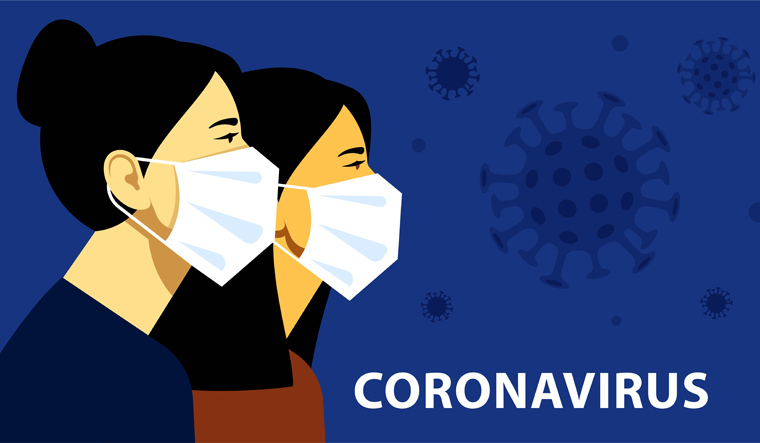

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=5d293da612dde69f95d6e03b98c089756c923fb7190cb20ef2fabc2fba217696
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
INIT_LR = 1e-4
EPOCHS = 14
BS = 32

In [5]:
print(os.listdir("../input"))

['inceptionv3', 'keras-pretrained-models', 'inception-v3', 'group-member', 'mask-dataset', 'vgg16']


In [6]:
imagePaths = list(paths.list_images('../input/mask-dataset/dataset/with_mask'))

print(len(imagePaths))


2018


In [7]:
imagePaths = list(paths.list_images('../input/mask-dataset/dataset/without_mask'))

print(len(imagePaths))


1946


In [8]:
imagePathsMask = list(paths.list_images('../input/mask-dataset/dataset/with_mask'))

print(type(imagePathsMask))

<class 'list'>


In [9]:
imagePathsWoMask = list(paths.list_images('../input/mask-dataset/dataset/without_mask'))

print(type(imagePathsWoMask))

<class 'list'>


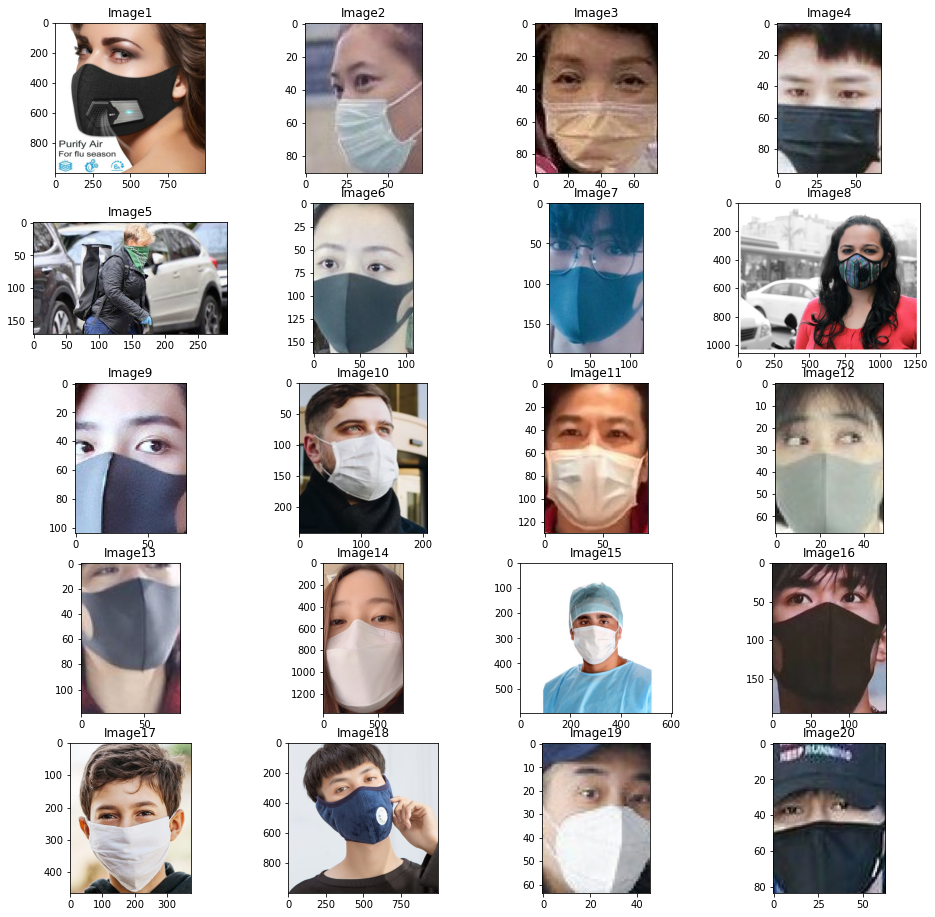

In [10]:
import matplotlib.pyplot as plt
k=1
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePathsMask[k])
    plt.imshow(t)
    k+=1

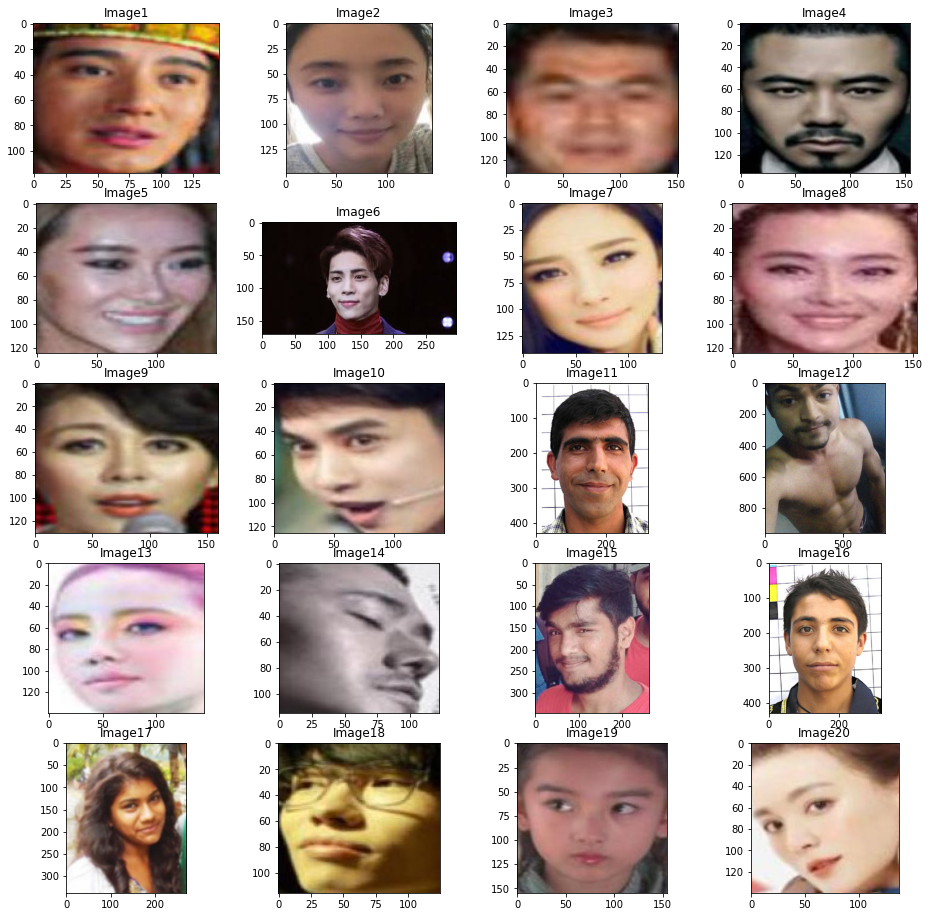

In [11]:
import matplotlib.pyplot as plt
k=1
imagenumber=50
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePathsWoMask[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1

In [12]:
data = []
labels = []

In [13]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('../input/mask-dataset/dataset/with_mask'))
# loop over the image paths
for imagePath in imagePaths:
	# label
	label ="with"

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)



[INFO] loading images...


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('../input/mask-dataset/dataset/without_mask'))

print(len(imagePaths))
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label ="without"# imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)



[INFO] loading images...
1946


In [15]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [16]:
print(len(data))
print(len(labels))

3964
3964


In [17]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [18]:
labels.shape

(3964, 2)

In [19]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)


# Data Augmentation

In [20]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


# VGG16

In [21]:
from tensorflow.keras.applications import VGG16
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = VGG16(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [22]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
92/92 [==============================] - 42s 452ms/step - loss: 0.6925 - accuracy: 0.5736 - val_loss: 0.5043 - val_accuracy: 0.8870
Epoch 2/10
92/92 [==============================] - 40s 433ms/step - loss: 0.5338 - accuracy: 0.7476 - val_loss: 0.3822 - val_accuracy: 0.9425
Epoch 3/10
92/92 [==============================] - 40s 435ms/step - loss: 0.4105 - accuracy: 0.8616 - val_loss: 0.3002 - val_accuracy: 0.9435
Epoch 4/10
92/92 [==============================] - 40s 430ms/step - loss: 0.3395 - accuracy: 0.8953 - val_loss: 0.2415 - val_accuracy: 0.9526
Epoch 5/10
92/92 [==============================] - 41s 443ms/step - loss: 0.2945 - accuracy: 0.9085 - val_loss: 0.2012 - val_accuracy: 0.9586
Epoch 6/10
92/92 [==============================] - 41s 444ms/step - loss: 0.2557 - accuracy: 0.9228 - val_loss: 0.1750 - val_accuracy: 0.9647
Epoch 7/10
92/92 [==============================] - 40s 434ms/step - loss: 0.2311 - accuracy

In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

trainlabels=[]
for x,y in trainY:
    if(x==1):
        trainlabels.append(0)
    else:
        trainlabels.append(1)
        
testlabels=[]
for x,y in testY:
    if(x==1):
        testlabels.append(0)
    else:
        testlabels.append(1)

from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(testlabels, predIdxs))
print("f1_score",f1_score(testlabels, predIdxs))
        

[INFO] evaluating network...
[[493  11]
 [ 17 470]]
f1_score 0.9710743801652894


# MobileNetv2

In [24]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


In [25]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
92/92 [==============================] - 37s 398ms/step - loss: 0.3368 - accuracy: 0.8504 - val_loss: 0.1120 - val_accuracy: 0.9738
Epoch 2/10
92/92 [==============================] - 37s 398ms/step - loss: 0.1152 - accuracy: 0.9646 - val_loss: 0.0693 - val_accuracy: 0.9788
Epoch 3/10
92/92 [==============================] - 37s 399ms/step - loss: 0.0762 - accuracy: 0.9765 - val_loss: 0.0611 - val_accuracy: 0.9768
Epoch 4/10
92/92 [==============================] - 36s 390ms/step - loss: 0.0694 - accuracy: 0.9755 - val_loss: 0.0492 - val_accuracy: 0.9849
Epoch 5/10
92/92 [==============================] - 37s 405ms/step - loss: 0.0612 - accuracy: 0.9799 - val_loss: 0.0413 - val_accuracy: 0.9869
Epoch 6/10
92/92 [==============================] - 37s 402ms/step - loss: 0.0569 - accuracy: 0.9827 - val_loss: 0.0421 - val_accuracy: 0.9828
Epoch 7/10
92/92 [==============================] - 38s 415ms/step - loss: 0.0441 - accuracy

In [26]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

trainlabels=[]
for x,y in trainY:
    if(x==1):
        trainlabels.append(0)
    else:
        trainlabels.append(1)
        
testlabels=[]
for x,y in testY:
    if(x==1):
        testlabels.append(0)
    else:
        testlabels.append(1)
        
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(testlabels, predIdxs))
print("f1 score",f1_score(testlabels, predIdxs))

[INFO] evaluating network...
[[499   5]
 [  9 478]]
f1 score 0.9855670103092783


# InceptionV3

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.layers as layers
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = InceptionV3(weights='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = layers.Flatten()(baseModel.output)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [28]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
92/92 [==============================] - 40s 440ms/step - loss: 0.1655 - accuracy: 0.9534 - val_loss: 0.0148 - val_accuracy: 0.9950
Epoch 2/10
92/92 [==============================] - 38s 416ms/step - loss: 0.0764 - accuracy: 0.9755 - val_loss: 0.0181 - val_accuracy: 0.9909
Epoch 3/10
92/92 [==============================] - 38s 408ms/step - loss: 0.0565 - accuracy: 0.9823 - val_loss: 0.0138 - val_accuracy: 0.9950
Epoch 4/10
92/92 [==============================] - 39s 421ms/step - loss: 0.0426 - accuracy: 0.9850 - val_loss: 0.0216 - val_accuracy: 0.9919
Epoch 5/10
92/92 [==============================] - 37s 407ms/step - loss: 0.0648 - accuracy: 0.9820 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 6/10
92/92 [==============================] - 38s 408ms/step - loss: 0.0501 - accuracy: 0.9861 - val_loss: 0.0127 - val_accuracy: 0.9970
Epoch 7/10
92/92 [==============================] - 39s 420ms/step - loss: 0.0358 - accuracy

In [29]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

trainlabels=[]
for x,y in trainY:
    if(x==1):
        trainlabels.append(0)
    else:
        trainlabels.append(1)
        
testlabels=[]
for x,y in testY:
    if(x==1):
        testlabels.append(0)
    else:
        testlabels.append(1)
        
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(testlabels, predIdxs))
print("f1 score",f1_score(testlabels, predIdxs))

[INFO] evaluating network...
[[504   0]
 [  2 485]]
f1 score 0.9979423868312758


Inceptionv3 with pretained weights worked best with approx 0.99 f1 score.

# Evaluation of MobileNetV2 using Graphs

In [30]:
yt=model.predict(trainX, batch_size=BS)
yt=np.argmax(yt,axis=1)

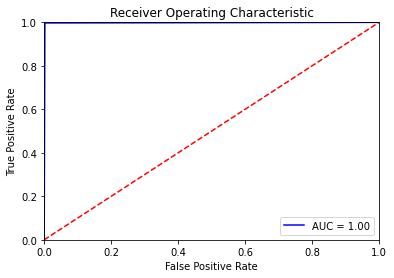

In [31]:
#roc_auc curve for training data
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(trainlabels,yt )
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

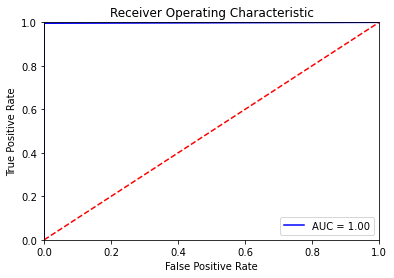

In [32]:
#roc_auc curve for test data
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testlabels, predIdxs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
data=[]
test_image_path=list(paths.list_images('../input/group-member'))
print(test_image_path)
for imagePath in test_image_path:
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)


['../input/group-member/groupmembermask/marro.jpg', '../input/group-member/groupmembermask/jaanwar.jpg', '../input/group-member/groupmembermask/ss.jpg', '../input/group-member/groupmembermask/apoorv.jpeg', '../input/group-member/groupmembermask/Nikhil.jpg', '../input/group-member/groupmembermask/pranav.jpg']


In [34]:
data=np.array(data,dtype='float32')

In [35]:
pred=model.predict(data, batch_size=32)
pred = np.argmax(pred, axis=1)

In [36]:
print(pred)

[0 0 0 1 0 0]


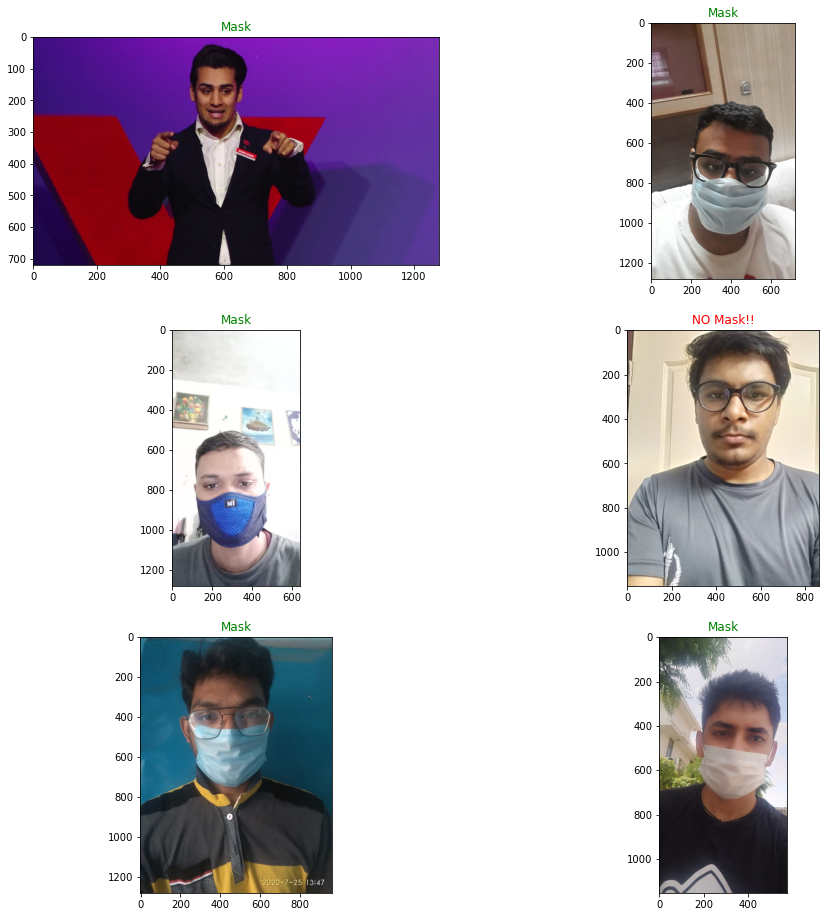

In [37]:
import matplotlib.pyplot as plt
k=1
imagenumber=0
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,3):
  for y in range(0,2):
    plt.subplot(3,2,k)
    s=""
    if(pred[k-1]==0):
      s="Mask"
      c='g'
    else:
      s="NO Mask!!"
      c='r'
    pob=plt.title(s)
    plt.setp(pob,color=c)
    t=plt.imread(test_image_path[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1
